## Notebook for exploration of NN methods (mostly for personal learning)

In [1]:
import astropy.io.fits as fits
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import funclib


/home/lzucker1/miniconda3/envs/general/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### PyTorch

##### PRACTICE WITH LAYER TYPES

In [1]:
import torch
from torch import nn

# LINEAR LAYER 
# B hand
x = torch.tensor([1,2,3,4], dtype=torch.float32) # inputs [4]
theta = torch.tensor([[0,0,0,0],  # wieghts [3, 4]
                      [1,1,1,1],
                      [2,2,2,2]], dtype=torch.float32)
x_new = theta.matmul(x) # outputs [3]
print(x_new)
# In PyTorch
# Note: will NOT get the n_new, becasue uses RANDOM theta matrix (since the point is the trianing fills it). 
# If really wanted, could set linear1.wieght = nn.Parameter(theta) (ever be usefull? Perhaps some initialization?)
# Also adds a small (random?) bias to each x_new (again, getting this value is the point of training)
# If really wanted, could set bias=False
linear1 = nn.Linear(in_features=4, out_features=3) 
x_new = linear1(x) 
print(x_new)

# CONVOLUTIONAL LAYER
# In PyTorch
x = torch.tensor([[0,1,1,0,0,0],  # wieghts [3, 4]
                  [0,1,1,0,0,0],
                  [0,1,1,0,0,0],
                  [0,0,1,1,0,0],
                  [0,0,0,0,1,1]], dtype=torch.float32)
in_channels = 1 # number of features? Like, would I pass x1, x2, x3 images (e.g. og_val, gradx, grady) and set in_channels=3?
out_channels = 1 # THIS IS ACTUALLY THE NUMBER OF FILTERS IN THE LAYER, each one produces a distinct output arrays "feature maps"
kernel_size = 3 # size of the filter (e.g kernal_size^2)
stride = 1 # num pix to slide over after each application of the filter
padding = 'same' # pad such that output is same dim as input
conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding)   

# ACCESSING THESE LAYERS AS PART OF A NN
# Define class MyNeuralNet
class MyNeuralNet(nn.Module):
  def __init__(self):
    super(MyNeuralNet, self).__init__()
    self.linear1 = nn.Linear(in_features=4, out_features=3) 
    self.conv1 = nn.Conv2d(in_channels=2, out_channels=3, kernel_size=4, stride=1, padding='same')  
    self.conv3 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=4, stride=1, padding='same') 
nn = MyNeuralNet()
print(nn.conv1)
print(nn.conv1.weight.shape) # tensor of shape  [2, 2, 4, 4] becasue 2 in_channels (feature images), 3 out_channels (two filters)
    


KeyboardInterrupt: 

#### TUTORIALS

#####  1) Simple PyTorch tutorial https://medium.com/analytics-vidhya/a-simple-neural-network-classifier-using-pytorch-from-scratch-7ebb477422d2 

In [91]:
from sklearn.datasets import make_classification
import torch
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch import nn

# Define Data class for ease of access 
class Data(Dataset):

  def __init__(self, X_train, y_train):
    self.X = torch.from_numpy(X_train.astype(np.float32))
    self.y = torch.from_numpy(y_train).type(torch.LongTensor)
    self.len = self.X.shape[0]
  
  def __getitem__(self, index):
    return self.X[index], self.y[index]
    
  def __len__(self):
    return self.len

# Generate fake data
X, Y = make_classification(n_samples=100, n_features=4, n_redundant=0, n_informative=3,  n_clusters_per_class=2, n_classes=3)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
batch_size = 3
traindata = Data(X_train, Y_train)
trainloader = DataLoader(traindata, batch_size=batch_size, shuffle=True, num_workers=2)
testdata = Data(X_test, Y_test)
testloader = DataLoader(testdata, batch_size=batch_size, shuffle=True, num_workers=2)

print('Test data:')
print('     '+str(X_test.shape[0])+' obs, with '+str(str(X_test.shape[1]))+' features')
print('     '+str(len(np.unique(Y_test)))+' unique target values: ', np.unique(Y_test))
print('     '+str(X_test.shape[0]/batch_size)+' batches of '+str(batch_size)+' obs each')
print('     '+str(len(testloader))+' sets in the dataloader')
print('Test data:')
n_batch = len(testloader)
n_obsperbatch = len(list(testloader)[0][0]) # same as len(list(testloader)[0][1])
n_featperobs = len(list(testloader)[0][0][0])
print('     '+str(n_batch*n_obsperbatch)+' obs, with '+str(n_featperobs)+' features')
print('     '+str(n_batch)+' batches of '+str(n_obsperbatch)+' obs each (last one has less if not evenly divisible)')
print('     '+str(len(testloader))+' sets in the dataloader')

a=b

input_dim = 4 # number of features (len of X cols)
hidden_layers = 25 # really num nodes in hidden layer??
output_dim = 3 # number of classes (unique of y)

# Define class MyNeuralNet
class MyNeuralNet(nn.Module):

  def __init__(self): 
    super(MyNeuralNet, self).__init__()
    self.linear1 = nn.Linear(input_dim, hidden_layers) 
    self.linear2 = nn.Linear(hidden_layers, output_dim) # so becasue output_dim is num classes, outputs will be class probs?
    
  def forward(self, x):
    x = torch.sigmoid(self.linear1(x))
    x = self.linear2(x)
    return x

# Define model (as an instance of MyNeuralNet), loss function and optimizer
model = MyNeuralNet()
print('model: \n', model)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1) # lr is learning rate

# Train
epochs = 2
for epoch in range(epochs):
  running_loss = 0.0
  for i, data in enumerate(trainloader, 0):
    inputs, labels = data
    optimizer.zero_grad()
    outputs = model(inputs) # outputs is n_obs times output_dim -> prob of each class?
    loss = loss_fn(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
  print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.5f}')

# Save the trained NN
torch.save(model.state_dict(), 'NN_tutorial.pth')

# Read it back in 
net = MyNeuralNet()
net.load_state_dict(torch.load('NN_tutorial.pth'))

# Test 
correct, total = 0, 0
batch = 0
with torch.no_grad():
  for data in testloader:
    inputs, labels = data
    y_hat = model(inputs)  # [4, 3] : Weights of each class for each obs (so y_hat is 4 obs by 3 wieghts big)
    wieghts, y_pred = torch.max(y_hat.data, 1) # [4], [4] : Returns most probable class and wieght (but documentation says idx??) of that class for each obs (so weights and y_pred are 1D of length n_obs). NOTE: how the heck does this function return the actual class, since I dont input them?
    print('Batch: ', batch)
    print('   y_hat: ', y_hat)
    print('   First few true: ', labels[0:6])
    print('   First few pred:', y_pred[0:6])
    print('   Wgts of these pred:', wieghts[0:6])
    total += labels.size(0)
    correct += (y_pred == labels).sum().item()
    batch +=1
print(f'Accuracy of the network on the {len(testdata)} test data: {100 * correct // total} %')

Test data:
     33 obs, with 4 features
     3 unique target values:  [0 1 2]
     11.0 batches of 3 obs each
     11 sets in the dataloader
Test data:
[tensor([[ 1.7681, -1.9083,  1.0539, -1.6828],
        [ 1.2031, -1.5322,  1.2384, -0.5025],
        [ 1.5605,  3.5121,  2.4255,  1.1760]]), tensor([1, 0, 0])]


NameError: name 'b' is not defined

##### 2) More complex PyTorch tutorial (doing regression) https://www.youtube.com/watch?v=SDPeeX6LEnk&t=907s 

In [11]:
'''
Main difference -> instead of just training for N epochs, also tests for each of those epochs. Not yet really sure if thats necesary.
                -> regression, so instead of model outputting prob of each class, outputs just prediction?
'''

import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch import nn

train_df = pd.read_csv('../NN_testdata/california_housing_train.csv')
test_df = pd.read_csv('../NN_testdata/california_housing_test.csv')

# Set up training and testing data
batch_size = 40
X_train = train_df.to_numpy()[:, :-1]
Y_train = train_df.to_numpy()[:, -1]
X_test = test_df.to_numpy()[:, :-1]
Y_test = test_df.to_numpy()[:, -1]
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float), torch.tensor(Y_train, dtype=torch.float))
train_dataloader = DataLoader(train_dataset, batch_size=batch_size) # not sure what 'batch_size' does. Defualts to 1.
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float), torch.tensor(Y_test, dtype=torch.float))
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

print('Test data:')
print('     '+str(X_test.shape[0])+' obs, with '+str(str(X_test.shape[1]))+' features')
print('     '+str(len(np.unique(Y_test)))+' unique target values: ', np.unique(Y_test))
print('     '+str(X_test.shape[0]/batch_size)+' batches of '+str(batch_size)+' obs each')
print('     '+str(len(test_dataloader))+' sets in the dataloader')

# Define class MyNeuralNet
class MyNeuralNet(nn.Module):

    def __init__(self):
        # Call init method inherated from nn.Module
        super(MyNeuralNet, self).__init__()
        # Define layers (not necesarily in order)
        self.hidden_layer_1 = nn.Linear(8, batch_size) # input and output dimensions - so should 8 be X_train.shape[1], 64 is batch_size I guess?
        self.hidden_activation = nn.ReLU()
        self.out = nn.Linear(batch_size, 1)
    
    def forward(self, x):
        # Run the NN by calling the layers on the data
        x = self.hidden_layer_1(x)
        x = self.hidden_activation(x)
        x = self.out(x)
        return x

# Define model (as an instance of MyNeuralNet), loss function and optimizer
model = MyNeuralNet().to('cpu')
print('Model: \n', model)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01) # lr is learning rate

# Define training function
def train(dataloader, model, loss_fn, optimizer):
    print('Training - ')
    model.train() # set model into training mode
    loss = 0
    for i, (X, y) in enumerate(dataloader):
        X, y = X.to('cpu'), y.to('cpu')
        y_hat = model(X)
        err = loss_fn(y_hat, y)
        loss += err.item() # .item gets the value from the nn.MSELoss object
        optimizer.zero_grad() # set derivatives to zero
        err.backward() # do a "backwards pass" on anything thats trainable in model to get derivative
        optimizer.step() # step according to the gradients
    num_batches =  len(dataloader)
    train_loss = loss/num_batches
    print('     Avg train loss per batch: ', train_loss)

# Define testing function
def test(dataloader, model, loss_fn):
    print('Testing - ')
    model.eval() # set model into evaluation mode
    loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to('cpu'), y.to('cpu')
            y_hat = model(X)  # [40,1] - this model does regression, so just returns value not class weigts?
            # wieghts, y_pred = torch.max(y_hat.data, 1) # so dont need this? (I added it)
            err = loss_fn(y_hat, y)
            loss += err.item() # .item gets the value from the nn.MSELoss object
    num_batches = len(dataloader)
    test_loss = loss/num_batches
    print('     Avg test loss per batch: ', test_loss)

# For a bunch of epochs, train and test
epochs = 10
for epoch in range(epochs):
    print('EPOCH ', epoch)
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)

# Save the trained NN
torch.save(model.state_dict(), 'NN_tutorial2.pth')



shape X_trian  (17000, 8)
shape Y_trian  (17000,)


NameError: name 'b' is not defined

##### 3) Convolutional Nueral Net 

##### 4) UNet https://medium.com/mlearning-ai/semantic-segmentation-with-pytorch-u-net-from-scratch-502d6565910a 

In [64]:
'''
Tutorial 1
Semantic segmentation using a CNN (but NOT a UNet)
Main difference to "normal" NN is CNN does operations on 2D arrays not just 1D input vectors
'''

import torch
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch import nn

# Define class MyBlock, with which to build blocks of layers
class MyBlock(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=0):
        # Call init method inherated from nn.Module
        super(MyBlock, self).__init__()
        # Define block of layers (?)
        self.seq_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True))

    def forward(self, x):
        x = self.seq_block(x)
        return x

# Define class MyBlocks using MyBlock, with which to build Encoder and Decoder 
class MyBlocks(nn.Module):

    def __init__(self,  n_conv, in_channels, out_channels, padding):
        # Call init method inherated from nn.Module
        super(CNNBlocks, self).__init__()
        # Initialize list of layers
        self.layers = nn.ModuleList()
        # Fill list of layers with layer blocks defined with MyBlock
        for i in range(n_conv):
            self.layers.append(MyBlock(in_channels, out_channels, padding=padding))
            # after each convolution we set (next) in_channel to (previous) out_channels
            in_channels = out_channels

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

# Define class MyEncoder that will become part of MyUNet
class MyEncoder(nn.Module):

    def __init__(self,  in_channels, out_channels, padding, downhill=4):
        # Call init method inherated from nn.Module
        super(Encoder, self).__init__()
        # Initialize list of layers
        self.enc_layers = nn.ModuleList()
        # Fill list of layers with layer blocks with blocks defined with MyBlocks
        for _ in range(downhill):
            self.enc_layers += [
                    MyBlocks(n_conv=2, in_channels=in_channels, out_channels=out_channels, padding=padding),
                    nn.MaxPool2d(2, 2)]
            # after each convolution we set (next) in_channel to (previous) out_channels    
            in_channels = out_channels
            out_channels *= 2
        # double the dept of the last CNN block
        self.enc_layers.append(CNNBlocks(n_conv=2, in_channels=in_channels, out_channels=out_channels, padding=padding))

    def forward(self, x):
        route_connection = []
        for layer in self.enc_layers:
            if isinstance(layer, MysBlocks):
                x = layer(x)
                route_connection.append(x)
            else:
                x = layer(x)
        return x, route_connection


# Define class MyDecoder that will become part of MyUNet
class MyDecoder(nn.Module):

    def __init__(self, in_channels, out_channels, exit_channels, padding, uphill=4):
        # Call init method inherated from nn.Module
        super(MyDecoder, self).__init__()
        # Set 
        self.exit_channels = exit_channels
        # Initialize list of layers
        self.layers = nn.ModuleList()
        # Fill list of layers with layer blocks with blocks defined with MyBlocks (and a ConvTranspose layer?)
        for i in range(uphill):
            self.layers += [
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
                MyBlocks(n_conv=2, in_channels=in_channels, out_channels=out_channels, padding=padding),]
            in_channels //= 2
            out_channels //= 2

        # 1) cannot be a CNNBlock because it has ReLU incorpored
        # 2) cannot append nn.Sigmoid here because you should be later using
        #    BCELoss () which will trigger the amp error "are unsafe to autocast".
        self.layers.append(
            nn.Conv2d(in_channels, exit_channels, kernel_size=1, padding=padding),)



##### 5) UNet  https://www.youtube.com/watch?v=IHq1t7NxS8k&t=3s

In [31]:
'''
UNet tutorial 2 (code at https://github.com/aladdinpersson/Machine-Learning-Collection/tree/master/ML/Pytorch/image_segmentation/semantic_segmentation_unet)
Can't actualy make this run - takes way to long.
'''

import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
import os
from PIL import Image
from torch.utils.data import Dataset, TensorDataset, DataLoader
import albumentations as alb
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import torch.optim as optim
import numpy as np


# Creat class for convenience to load in data (inherates from torch Dataset class)
class CarvanaDataset(Dataset):

    # Set attributes for the image data and label dirs and transform to use (passed in) and put image data files in list
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    # So can call CarvanaDataset.len?
    def __len__(self):
        return len(self.images)

    # How do you use this???
    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index]) # path to one data image
        mask_path = os.path.join(self.mask_dir, self.images[index].replace(".jpg", "_mask.gif")) # path to one labels image (and change file ext)
        image = np.array(Image.open(img_path).convert("RGB")) # convert to RBG - is this then a [3, npix, npix] array?
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)
        mask[mask == 255.0] = 1.0 # want masks to be 1s and 0s, but currently car = 255
        # 
        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        return image, mask

# Define class DoubleConv to create a containor for multiple layers (for convenience)
class DoubleConv(nn.Module):

    def __init__(self, in_channels, out_channels):
        # Call init method inherated from nn.Module
        super(DoubleConv, self).__init__()
        # Define layer that is a bunch of layers
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding='same', bias=False),
            nn.BatchNorm2d(out_channels), # 
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding='same', bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),)

    def forward(self, x):
        return self.conv(x)

# Define class MyUNet
class MyUNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],): # features is num features?
        
        # Call init method inherated from nn.Module
        super(MyUNet, self).__init__()
        # Initialize two lists of layers: one for down one for up
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        # Define pooling layer (recall: this is not saying the pooling layer is called after the up and down stuff; its just defining the up, down, and pool attributes all together here)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fill list of down layers 
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            # after each convolution we set (next) in_channel to (previous) out_channels  
            in_channels = feature

        # Fill list of up layers 
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2,))
            self.ups.append(DoubleConv(feature*2, feature))

        # Define ayer at the bottom (??????)
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)

        # Define last conv to get correct output num channels
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):

        # Initialize list to store skip connections
        skip_connections = []

        # Do all the downs in self.downs
        for down in self.downs:
            x = down(x)
            skip_connections.append(x) # NEED TO LEARN ABOUT SKIP_CONNECTIONS
            x = self.pool(x)

        # Perform bottleneck layer
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1] # reverse 

        # Do all the ups in self.ups
        for idx in range(0, len(self.ups), 2): # step of 2 becasue add conv step
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]
            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])
            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

# Create training function to train one epoch
def train_fn(loader, model, optimizer, loss_fn, scaler):
    
    loop = tqdm(loader) # is this a progress bar? but then below its looping through loop

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device="cpu")
        targets = targets.float().unsqueeze(1).to(device="cpu")

        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())

# Get the data, applying some transformations
batch_size = 16
height = 160; width = 240  # cut image to this size, from original [1280, 1918]
train_transform = alb.Compose([alb.Resize(height, width), alb.Rotate(limit=35, p=1.0), alb.HorizontalFlip(p=0.5), alb.VerticalFlip(p=0.1),
                               alb.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0], max_pixel_value=255.0), ToTensorV2()])
val_transform = alb.Compose([alb.Resize(height, width), alb.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0], max_pixel_value=255.0),
                              ToTensorV2()])
train_ds = CarvanaDataset(image_dir="../NN_testdata/CarData/train/train", mask_dir="../NN_testdata/CarData/train_masks/train_masks", transform=train_transform)
train_loader = DataLoader(train_ds, batch_size=batch_size, num_workers=2, pin_memory=True, shuffle=True)
val_ds = CarvanaDataset(image_dir="../NN_testdata/CarData/test/test", mask_dir="../NN_testdata/CarData/test_hq/test_hq", transform=val_transform)
val_loader = DataLoader(val_ds, batch_size=batch_size, num_workers=2, pin_memory=True, shuffle=False)

# Check data is loaded correctly
print('Train data:')
print(f'     {len(train_ds)} obs, broken into {len(train_loader)} batches')
train_features, train_labels = next(iter(train_loader))
shape = train_features.size()
print(f'     Each batch is shape {train_features.size()}, e.g. {shape[0]} images, {[shape[2], shape[3]]} pixels each, {shape[1]} layers (features)')

# Define model (as an instance of MyNeuralNet), loss function, and optimizer
model = MyUNet(in_channels=3, out_channels=1).to("cpu") #  NOTE: FOR MULTICLASS, CHANGE OUT_CHANNELS TO NUM CLASSES!!!
print('model: \n', model)
loss_fn = nn.BCEWithLogitsLoss() # NOTE: FOR MULTICLASS, USE CROSS ENTROPY LOSS!!!
optimizer = optim.Adam(model.parameters(), lr=1e-4)
load_model = False
if load_model:
    checkpoint = torch.load("my_checkpoint.pth.tar")
    model.load_state_dict(checkpoint["state_dict"])

# check accuracy (e.g. test? why are we doing that before any training???) NOTE: WILL NOT WORK FOR MULTICLASS
num_correct = 0
num_pixels = 0
dice_score = 0
model.eval() # set model into eval mode
with torch.no_grad():
    for x, y in val_loader:
        x = x.to("cpu")
        y = y.to("cpu").unsqueeze(1)
        preds = torch.sigmoid(model(x)) # call model to get predictions
        preds = (preds > 0.5).float()
        num_correct += (preds == y).sum()
        num_pixels += torch.numel(preds)
        dice_score += (2 * (preds * y).sum()) / ((preds + y).sum() + 1e-8)
print(f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}")
print(f"Dice score: {dice_score/len(loader)}")
model.train() # set model back into train mode

# Train 
num_epochs = 3
scaler = torch.cuda.amp.GradScaler()
for epoch in range(num_epochs):

    # Train on thi
    train_fn(train_loader, model, optimizer, loss_fn, scaler)

    # Save a snapshot of the trained model training up untill this point (why would you want to save a checkpoint?)
    state = {"state_dict": model.state_dict(), "optimizer":optimizer.state_dict(),}
    torch.save(state, "my_checkpoint.pth.tar")

    # check accuracy (e.g. test? during the training?) NOTE: WILL NOT WORK FOR MULTICLASS
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval() # set model into eval mode
    with torch.no_grad():
        for x, y in val_loader:
            x = x.to("cpu")
            y = y.to("cpu").unsqueeze(1)
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / ((preds + y).sum() + 1e-8)
    print(f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}")
    print(f"Dice score: {dice_score/len(loader)}")
    model.train() # set model back into train mode

    # print some examples to a folder
    model.eval() # set model into eval mode
    for idx, (x, y) in enumerate(val_loader):
        x = x.to(device="cpu")
        with torch.no_grad():
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float() 
        torchvision.utils.save_image(preds, f"saved_images/pred_{idx}.png")
        torchvision.utils.save_image(y.unsqueeze(1), f"saved_images/true_{idx}.png")
    model.train() # set model back into train mode




Train data:
     5088 obs, broken into 318 batches
     Each batch is shape torch.Size([16, 3, 160, 240]), e.g. 16 images, [160, 240] pixels each, 3 layers (features)
     Each batch has labels of shape torch.Size([16, 160, 240])


NameError: name 'b' is not defined

In [ ]:
'''
Tutorial 3) https://www.youtube.com/watch?v=GAYJ81M58y8&t=3s
'''

#### APPLICATIONS

##### Tutorial (1) method

In [43]:
'''
Tutorial (1) method
On much reduced data so I can run locally 
- Should be similar to tutorial data - predict small number of numerical class labels from small number of numerical feats
- WHY ARE ALL THE CLASS WEIGHTS THE SAME FOR EVERY OBS!?!
    Is this model just terrible for this task? always predicts class 0
    Maybe I need a to use an architecture specific to image segmentation -  UNet?
'''

import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch import nn

batch_size = 20

# Get data (DKIST images) and labels 
data = fits.open("../Data/DKIST_example.fits")[0].data.byteswap().newbyteorder()[0:500, 0:500]
labels = np.squeeze(fits.open("../Data/DKIST_solarseg_output.fits")[0].data)[0:500, 0:500]
for file in os.listdir('../Data/DKIST_gband_series_183653/'):
        if file.startswith('SEG_'):
            path = '../Data/DKIST_gband_series_183653/'+file
            data1 = fits.open(path)[1].data.byteswap().newbyteorder()[0:500, 0:500]
            data = np.concatenate((data, data1), axis=1)
            labels1 = np.squeeze(fits.open(path)[0].data)[0:500, 0:500]
            labels = np.concatenate((labels, labels1), axis=1)

# Prepare half for training and testing (split along 'short' axis to encompass all)
tt_data = data[0:int(np.shape(data)[0]/2), :]
tt_labels = labels[0:int(np.shape(data)[0]/2), :]
X_tt, Y_tt = funclib.pre_proccess(tt_data, tt_labels)
X_train, X_test, Y_train, Y_test = train_test_split(X_tt, Y_tt, test_size=0.4, random_state=20)

# Prepare other half for validation
tt_data = data[int(np.shape(data)[0]/2):-1, :]
tt_labels = labels[int(np.shape(data)[0]/2):-1, :]
X_val, Y_val = funclib.pre_proccess(tt_data, tt_labels)
# Set up training, testing, validation dataloaders
X_train_np = X_train.to_numpy() # convert df to np array (just turns into array by removing col names and row idx)
Y_train_np = Y_train #.reshape(-1, 1) WHY WAS i RESHAPING THESE? LOOKS LIKE ABOVE ITS SHAPE (N,) # already array, but reshape from (N,) to (N,1)
X_test_np = X_test.to_numpy() # convert df to np array (just turns into array by removing col names and row idx)
Y_test_np = Y_test #.reshape(-1, 1) # already array, but reshape from (N,) to (N,1)
X_val_np = X_val.to_numpy() # convert df to np array (just turns into array by removing col names and row idx)
Y_val_np = Y_val #.reshape(-1, 1) # already array, but reshape from (N,) to (N,1)
train_dataset = TensorDataset(torch.tensor(X_train_np, dtype=torch.float), torch.tensor(Y_train_np, dtype=torch.long)) # y's must be LongTensor (int) NOT float for classification
train_dataloader = DataLoader(train_dataset, batch_size=batch_size) # not sure what 'batch_size' does. Defualts to 1.
test_dataset = TensorDataset(torch.tensor(X_test_np, dtype=torch.float), torch.tensor(Y_test_np, dtype=torch.long))
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)
val_dataset = TensorDataset(torch.tensor(X_val_np, dtype=torch.float), torch.tensor(Y_val_np, dtype=torch.long))
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

print('Test data:')
print('     '+str(X_test_np.shape[0])+' obs, with '+str(str(X_test_np.shape[1]))+' features')
print('     '+str(len(np.unique(Y_test_np)))+' unique target values: ', np.unique(Y_test_np))
print('     '+str(X_test_np.shape[0]/batch_size)+' batches of '+str(batch_size)+' obs each')
print('     '+str(len(test_dataloader))+' sets in the dataloader')

input_dim = X_test_np.shape[1] # number of features (len of X cols)
hidden_layers = 25 # number of hidden layers
output_dim = len(np.unique(Y_test_np)) # number of classes (unique of y)

# Define class MyNeuralNet
class MyNeuralNet(nn.Module):

  def __init__(self):
    super(MyNeuralNet, self).__init__()
    self.linear1 = nn.Linear(input_dim, hidden_layers) 
    self.linear2 = nn.Linear(hidden_layers, output_dim) # so becasue output_dim is num classes, outputs will be class probs?
    
  def forward(self, x):
    x = torch.sigmoid(self.linear1(x))
    x = self.linear2(x)
    return x

# Define model (as an instance of MyNeuralNet), loss function and optimizer
model = MyNeuralNet()
print('model: \n', model)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1) # lr is learning rate

# Train
epochs = 2
for epoch in range(epochs):
  running_loss = 0.0
  for i, data in enumerate(train_dataloader, 0):
    inputs, labels = data
    optimizer.zero_grad()
    outputs = model(inputs) # outputs is n_obs times output_dim -> prob of each class?
    loss = loss_fn(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
  print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.5f}')

# Save the trained NN
torch.save(model.state_dict(), 'NN_tutorial.pth')

# Read it back in 
net = MyNeuralNet()
net.load_state_dict(torch.load('NN_tutorial.pth'))

# Test 
correct, total = 0, 0
batch = 0
with torch.no_grad():
  for data in test_dataloader:
    inputs, labels = data
    y_hat = model(inputs)  # WHY ARE ALL THE CLASS WIEGHTS THE SAME FOR EVERY OBS!?! # [20, 4] : Weights of each class for each obs (so y_hat is 20 obs by 4 class wieghts big)
    wieghts, y_pred = torch.max(y_hat.data, 1) # [4], [4] : Returns most probable class and wieght (but documentation says idx??) of that class for each obs (so weights and y_pred are 1D of length n_obs). NOTE: how the heck does this function return the actual class, since I dont input them?
    print('Batch: ', batch)
    print('   shape y_hat: ', y_hat.shape)
    print('   y_hat: ', y_hat)
    print('   First few true: ', labels[0:6])
    print('   First few pred:', y_pred[0:6])
    print('   Wgts of thess pred:', wieghts[0:6])
    a=b
    total += labels.size(0)
    correct += (y_pred == labels).sum().item()
    batch +=1
print(f'Accuracy of the network on the {len(X_test_np)} test data: {100 * correct // total} %')


Test data:
     500000 obs, with 6 features
     4 unique target values:  [0 1 2 3]
     25000.0 batches of 20 obs each
     25000 sets in the dataloader
model: 
 MyNeuralNet(
  (linear1): Linear(in_features=6, out_features=25, bias=True)
  (linear2): Linear(in_features=25, out_features=4, bias=True)
)
[1, 37500] loss: 14.29524
[2, 37500] loss: 14.29498
Batch:  0
   shape y_hat:  torch.Size([20, 4])
   y_hat:  tensor([[ 2.8297, -1.0105,  2.6696, -4.8646],
        [ 2.8297, -1.0105,  2.6696, -4.8646],
        [ 2.8297, -1.0105,  2.6696, -4.8646],
        [ 2.8297, -1.0105,  2.6696, -4.8646],
        [ 2.8297, -1.0105,  2.6696, -4.8646],
        [ 2.8297, -1.0105,  2.6696, -4.8646],
        [ 2.8297, -1.0105,  2.6696, -4.8646],
        [ 2.8297, -1.0105,  2.6696, -4.8646],
        [ 2.8297, -1.0105,  2.6696, -4.8646],
        [ 2.8297, -1.0105,  2.6696, -4.8646],
        [ 2.8297, -1.0105,  2.6696, -4.8646],
        [ 2.8297, -1.0105,  2.6696, -4.8646],
        [ 2.8297, -1.0105,  2.6696

NameError: name 'b' is not defined

##### Tutorial (2) method

In [35]:
'''
On much reduced data so I can run locally 
MAYBE I SHOULDNT TRY FORCING A REGRESSION MODEL INTO A CLASSIFICATION MODEL
'''

import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch import nn

batch_size = 20

# Get data (DKIST images) and labels 
data = fits.open("../Data/DKIST_example.fits")[0].data.byteswap().newbyteorder()[0:500, 0:500]
labels = np.squeeze(fits.open("../Data/DKIST_solarseg_output.fits")[0].data)[0:500, 0:500]
for file in os.listdir('../Data/DKIST_gband_series_183653/'):
        if file.startswith('SEG_'):
            path = '../Data/DKIST_gband_series_183653/'+file
            data1 = fits.open(path)[1].data.byteswap().newbyteorder()[0:500, 0:500]
            data = np.concatenate((data, data1), axis=1)
            labels1 = np.squeeze(fits.open(path)[0].data)[0:500, 0:500]
            labels = np.concatenate((labels, labels1), axis=1)

# Prepare half for training and testing (split along 'short' axis to encompass all)
tt_data = data[0:int(np.shape(data)[0]/2), :]
tt_labels = labels[0:int(np.shape(data)[0]/2), :]
X_tt, Y_tt = funclib.pre_proccess(tt_data, tt_labels)
X_train, X_test, Y_train, Y_test = train_test_split(X_tt, Y_tt, test_size=0.4, random_state=20)

# Prepare other half for validation
tt_data = data[int(np.shape(data)[0]/2):-1, :]
tt_labels = labels[int(np.shape(data)[0]/2):-1, :]
X_val, Y_val = funclib.pre_proccess(tt_data, tt_labels)

# Set up training, testing, validation dataloaders
X_train_np = X_train.to_numpy() # convert df to np array (just turns into array by removing col names and row idx)
Y_train_np = Y_train.reshape(-1, 1) # already array, but reshape from (N,) to (N,1)
X_test_np = X_test.to_numpy() # convert df to np array (just turns into array by removing col names and row idx)
Y_test_np = Y_test.reshape(-1, 1) # already array, but reshape from (N,) to (N,1)
X_val_np = X_val.to_numpy() # convert df to np array (just turns into array by removing col names and row idx)
Y_val_np = Y_val.reshape(-1, 1) # already array, but reshape from (N,) to (N,1)
train_dataset = TensorDataset(torch.tensor(X_train_np, dtype=torch.float), torch.tensor(Y_train_np, dtype=torch.float))
train_dataloader = DataLoader(train_dataset, batch_size=batch_size) # not sure what 'batch_size' does. Defualts to 1.
test_dataset = TensorDataset(torch.tensor(X_test_np, dtype=torch.float), torch.tensor(Y_test_np, dtype=torch.float))
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)
val_dataset = TensorDataset(torch.tensor(X_val_np, dtype=torch.float), torch.tensor(Y_val_np, dtype=torch.float))
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

print('Test data:')
print('     '+str(X_test_np.shape[0])+' obs, with '+str(str(X_test_np.shape[1]))+' features')
print('     '+str(len(np.unique(Y_test_np)))+' unique target values: ', np.unique(Y_test_np))
print('     '+str(X_test_np.shape[0]/batch_size)+' batches of '+str(batch_size)+' obs each')
print('     '+str(len(test_dataloader))+' sets in the dataloader')

# Define class MyNeuralNet
class MyNeuralNet(nn.Module):

    def __init__(self):
        # Call init method inherated from nn.Module?
        super(MyNeuralNet, self).__init__()
        # Define layers (not necesarily in order)
        self.hidden_layer_1 = nn.Linear(6, batch_size) # input and output dimensions - so should 8 be X_train.shape[1], 64 is batch_size I guess?
        self.hidden_activation = nn.ReLU()
        self.out = nn.Linear(batch_size, 1)
    
    def forward(self, x):
        # Run the NN by calling the layers on the data
        x = self.hidden_layer_1(x)
        x = self.hidden_activation(x)
        x = self.out(x)
        return x

# Define model (as an instance of MyNeuralNet), loss function and optimizer
model = MyNeuralNet().to('cpu')
print(f'Model: \n {model}')
loss_fn = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=0.01) # lr is learning rate

# Define training function
def train(dataloader, model, loss_fn, optimizer):
    model.train() # set model into training mode -I think this really only affects it if there are certain layers, but probabaly good practice
    loss = 0
    for i, (X, y) in enumerate(dataloader):
        X, y = X.to('cpu'), y.to('cpu')
        y_hat = model(X)
        err = loss_fn(y_hat, y)
        loss += err.item() # .item gets the value from the nn.MSELoss object
        optimizer.zero_grad() # ??
        err.backward() # do a "backwards pass" on anything thats trainable in model to get derivative??
        optimizer.step() # step according to the gradients
    num_batches =  len(dataloader)
    train_loss = loss/num_batches
    print('     Train loss: ', train_loss)

# Define testing function
def test(dataloader, model, loss_fn):
    model.eval() # set model into evaluation mode
    loss = 0
    batch = 0
    print('     Testing - ')
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to('cpu'), y.to('cpu')
            y_hat = model(X) # regression, so returns just value? but why are these like -3000 instead of like 1.2????
            # wieghts, y_pred = torch.max(y_hat.data, 1) # [20], [20] : Returns most probable class and wieght of that class for each obs (so weights and y_pred are 1D of length n_obs). NOTE: how the heck does this function return the actual class, since I dont input them?
            y_pred = torch.round(y_hat) # force this regression to be a classifcation
            print('         Batch '+str(batch)+' ('+str(len(y))+' obs)'); batch +=1
            print('                 First few true:', list(y[0:4]))
            print('                 First few pred:', list(y_pred[0:4]))
            err = loss_fn(y_hat, y)
            print('                 Loss: ', err.item()) 
            loss += err.item() # .item gets the value from the nn.MSELoss object
    num_batches =  len(dataloader)
    test_loss = loss/num_batches
    print('     Test loss: ', test_loss)

# For a bunch of epochs, train and test
epochs = 5
for epoch in range(epochs):
    print('Epoch ', epoch)
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)

# Save the trained NN
torch.save(MyNeuralNet.state_dict(), 'NN_1.pth')

# Load it back in and test it on validation data 
net = MyNeuralNet()
net.load_state_dict(torch.load('NN_1.pth'))
with torch.no_grad():
    for X, y in dataloader:
        X, y = X.to('cpu'), y.to('cpu')
        y_pred = net(X)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()


Test data:
     500000 obs, with 6 features
     4 unique target values:  [0 1 2 3]
     25000.0 batches of 20 obs each
     25000 sets in the dataloader
Model: 
 MyNeuralNet(
  (hidden_layer_1): Linear(in_features=6, out_features=20, bias=True)
  (hidden_activation): ReLU()
  (out): Linear(in_features=20, out_features=1, bias=True)
)
Epoch  0
     Train loss:  0.0
     Testing - 
tensor([[-3430.1694],
        [-4229.9966],
        [-4352.3003],
        [-3643.6829],
        [-3542.3149],
        [-4221.4209],
        [-4023.2756],
        [-3967.3345],
        [-4245.6001],
        [-4525.1704],
        [-3758.1208],
        [-4354.0942],
        [-4452.7627],
        [-4266.4658],
        [-3317.8650],
        [-3842.2131],
        [-3270.5098],
        [-3050.1604],
        [-3576.0190],
        [-2909.1121]])


NameError: name 'b' is not defined

##### Tutorial (5) method: UNET

In [ ]:
'''
UNet1 (binary labels)
'''
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import os
from PIL import Image
from torch.utils.data import Dataset, TensorDataset, DataLoader
from albumentations.pytorch import ToTensorV2
import torchvision 
import torchvision.transforms.functional as TF
from tqdm import tqdm
import torch.optim as optim

# Creat class for convenience to load in data (inherates from torch Dataset class)
class MyDataset(Dataset):

    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index]) # path to one data image
        mask_path = os.path.join(self.mask_dir, 'SEG_'+self.images[index]) # path to one labels image THIS SHOULD ENSURE ITS THE MASK CORRESPONDING TO THE CORRECT IMAGE
        img = np.load(img_path).newbyteorder().byteswap() 
        mask = np.load(mask_path).newbyteorder().byteswap() 
        if self.transform is not None:
            augmentations = self.transform(image=img, mask=mask)
            img = augmentations["image"]
            mask = augmentations["mask"]
        # Add dummy axis so that torch has correct number of dimensions
        image = np.zeros((1, img.shape[0], img.shape[1]), dtype=np.float32) # needs to be float32 not float64
        image[0, :, :] = img
        return image, mask

# Define class DoubleConv to create a containor for multiple layers (for convenience)
class DoubleConv(nn.Module):

    def __init__(self, in_channels, out_channels):

        # Call init method inherated from nn.Module
        super(DoubleConv, self).__init__()
        # Define layer that is a bunch of layers
        #print(f'\tin_channels {in_channels}, out_channels {out_channels}')
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding='same', bias=False),
            nn.BatchNorm2d(out_channels), 
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding='same', bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            )

    def forward(self, x): # this is what gets called when you call DoubleConv

        # print(f'\t\tCalling MyUNet.DoubleConv foward with x shape {x.shape}, with first Conv2d layer {self.conv[0]}')
        return self.conv(x)

# Define class MyUNet
class MyUNet(nn.Module):

    def __init__(self, in_channels=1, out_channels=1, features=[64, 128, 256, 512],): # Changed in_channels from 3 to 1, becasue I have 1-channel images not rgb
        
        print('Initializing MyUNet')

        # Call init method inherated from nn.Module
        super(MyUNet, self).__init__()
        # Initialize two lists of layers: one for down one for up
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        # Define pooling layer (recall: this is not saying the pooling layer is called after the up and down stuff; its just defining the up, down, and pool attributes all together here)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fill list of down layers 
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            # after each convolution we set (next) in_channel to (previous) out_channels  
            in_channels = feature

        # Fill list of up layers 
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2,))
            self.ups.append(DoubleConv(feature*2, feature))

        # Define layer at the bottom (??????)
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)

        # Define last conv to get correct output num channels
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x): # this is what gets called when you call MyUNet

        # Initialize list to store skip connections
        skip_connections = []

        # Do all the downs in self.downs
        #print(f'\tPerfoming downs:'); i = 0
        for down in self.downs:
            #print(f'\t{i}'); i += 1 
            x = down(x) # the down layers are all MyUNet.DoubleConv, which is a set of layers within a nn.Sequential containor 
            skip_connections.append(x) # NEED TO LEARN ABOUT SKIP_CONNECTIONS
            x = self.pool(x)

        # Perform bottleneck layer
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1] # reverse 

        # Do all the ups in self.ups
        for idx in range(0, len(self.ups), 2): # step of 2 becasue add conv step
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2] # // inte
            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])
            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

# Create training function to train one epoch
def train_fn(loader, model, optimizer, loss_fn, scaler):
    
    loop = tqdm(loader) # is this a progress bar? but then below its looping through loop

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device="cpu")
        targets = targets.float().unsqueeze(1).to(device="cpu")

        # forward
        # with torch.cuda.amp.autocast():
        #     predictions = model(data) # call model to get predictions # NOTE: wait, why not torch.sigmoid(model(x)) ??? Isnt that how we get the predictions??
        #     loss = loss_fn(predictions, targets) # compute loss
        predictions = model(data) # call model to get predictions  # NOTE: wait, why not torch.sigmoid(model(x)) ??? Isnt that how we get the predictions??
        loss = loss_fn(predictions, targets) # compute loss

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # # update tqdm loop
        loop.set_postfix(loss=loss.item()) # 
        # print(f'\t\tBatch {batch_idx}, loss={loss}')
 

# Get the data, applying some transformations
# Should pull segs and truths correctly based on thier positions in the directories
batch_size = 16
train_ds = MyDataset(image_dir="../Data/UNetData/images/train", mask_dir="../Data/UNetData/seg_images_binary/train")#, transform=train_transform)
train_loader = DataLoader(train_ds, batch_size=batch_size, num_workers=2, pin_memory=True, shuffle=True)
val_ds = MyDataset(image_dir="../Data/UNetData/images/val", mask_dir="../Data/UNetData/seg_images_binary/val")#, transform=val_transform)
val_loader = DataLoader(val_ds, batch_size=batch_size, num_workers=2, pin_memory=True, shuffle=False)

# Check data is loaded correctly
print('Train data:')
print(f'     {len(train_ds)} obs, broken into {len(train_loader)} batches')
train_features, train_labels = next(iter(train_loader))
shape = train_features.size()
print(f'     Each batch has data of shape {train_features.size()}, e.g. {shape[0]} images, {[shape[2], shape[3]]} pixels each, {shape[1]} layers (features)')

# Define model (as an instance of MyNeuralNet), loss function, and optimizer
model = MyUNet(in_channels=1, out_channels=1).to("cpu") # NOTE: FOR MULTICLASS, CHANGE OUT_CHANNELS TO NUM CLASSES!!!
#print('model: \n', model)
loss_fn = nn.BCEWithLogitsLoss() # NOTE: FOR MULTICLASS, USE CROSS ENTROPY LOSS!!!
optimizer = optim.Adam(model.parameters(), lr=1e-4)
load_model = False
if load_model:
    checkpoint = torch.load("my_checkpoint.pth.tar")
    model.load_state_dict(checkpoint["state_dict"])

# Train
print('Training:')
num_epochs = 3
scaler = torch.cuda.amp.GradScaler() # Don't have cuda
for epoch in range(num_epochs):
    print(f'\tEpoch {epoch}')

    # Train
    train_fn(train_loader, model, optimizer, loss_fn, scaler) # call model

    # check accuracy (e.g. test? during the training?) NOTE: WILL NOT WORK FOR MULTICLASS
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval() # set model into eval mode
    with torch.no_grad():
        for x, y in val_loader:
            x = x.to("cpu")
            y = y.to("cpu").unsqueeze(1)
            preds = torch.sigmoid(model(x)) # call model to get predictions
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / ((preds + y).sum() + 1e-8)
    print(f"\tGot {num_correct}/{num_pixels} correct (accuracy {num_correct/num_pixels*100:.2f})")
    print(f"\tDice score: {dice_score/len(val_loader)}")
    model.train() # set model back into train mode

# Save model
torch.save(model.state_dict(), '../NN_storage/UNet1.pth')
print('Saving trained model as NN_storage/UNet1.pth')

# Load it back in and save results on validation data 
model = MyUNet()
model.load_state_dict(torch.load('../NN_storage/UNet1.pth'))
print('Loading model back in, saving results on validation data in UNet1_outputs')
i = 0
for X, y in val_loader:
    X, y = X.to('cpu'), y.to('cpu')
    with torch.no_grad():
        preds = torch.sigmoid(model(X))
    preds = (preds > 0.5).float()
    for j in range(np.shape(preds)[0]):
        np.save(f'../UNet1_outputs/x_{i}', np.array(X[j]))
        np.save(f'../UNet1_outputs/true_{i}', np.array(y[j]))
        np.save(f'../UNet1_outputs/pred_{i}', np.array(preds[j]))
        i += 1


Total validation accuracy: 97.43


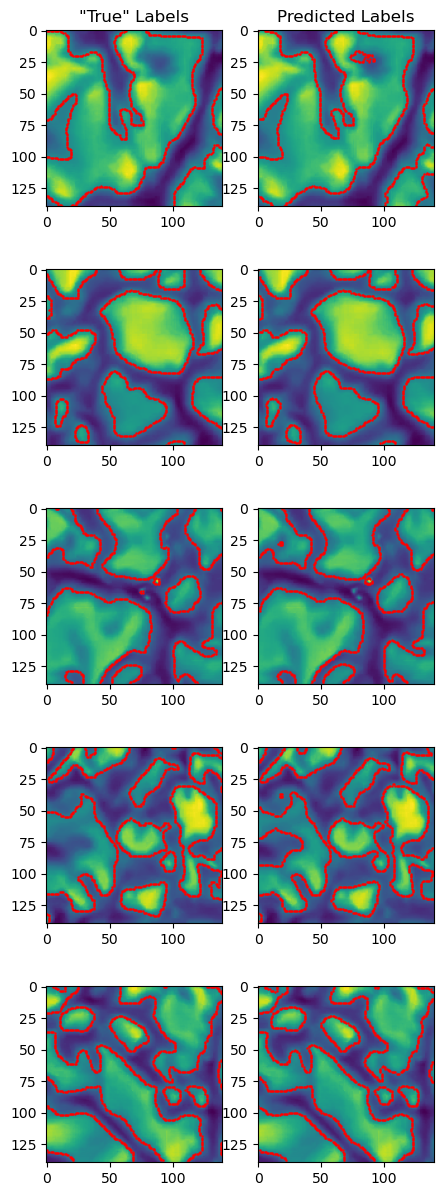

In [6]:
# Compute total validation accuracy
num_correct = 0
num_pixels = 0
for idx in range(396):
    true = np.load(f'../UNet1_outputs/true_{idx}.npy').astype(np.uint8)
    preds = np.squeeze(np.load(f'../UNet1_outputs/pred_{idx}.npy')).astype(np.uint8)
    num_correct += len(np.where(preds.flatten() == true.flatten())[0]) #(preds == y).sum()
    num_pixels += len(preds.flatten()) # torch.numel(preds)
print(f"Total validation accuracy: {num_correct/num_pixels*100:.2f}") 

# Display a random sample of images
import cv2
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10)) = plt.subplots(5, 2, figsize=(5, 15)); axs = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10]
ax1.set_title('"True" Labels')
ax2.set_title('Predicted Labels')
for i in range(0, 9, 2):
    idx = np.random.randint(0, 396)
    im = np.load(f'../UNet1_outputs/x_{idx}.npy')
    true = np.load(f'../UNet1_outputs/true_{idx}.npy').astype(np.uint8)
    preds = np.squeeze(np.load(f'../UNet1_outputs/pred_{idx}.npy')).astype(np.uint8)
    true_edges = cv2.Canny(true, 0, 1)
    pred_edges = cv2.Canny(preds, 0, 1)
    x_true = np.where(true_edges!=0)[0]
    y_true = np.where(true_edges!=0)[1]
    x_pred = np.where(pred_edges!=0)[0]
    y_pred = np.where(pred_edges!=0)[1]
    axs[i].imshow(im)
    axs[i].scatter(y_true, x_true, s=0.5, color='red')
    axs[i+1].imshow(im)
    axs[i+1].scatter(y_pred, x_pred, s=0.5, color='red')


In [ ]:
'''
UNet3 (binary labels, normalized data)
'''
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import os
from PIL import Image
from torch.utils.data import Dataset, TensorDataset, DataLoader
from albumentations.pytorch import ToTensorV2
import torchvision 
import torchvision.transforms.functional as TF
from tqdm import tqdm
import torch.optim as optim


# Creat class for convenience to load in data (inherates from torch Dataset class)
class MyDataset(Dataset):

    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index]) # path to one data image
        mask_path = os.path.join(self.mask_dir, 'SEG_'+self.images[index]) # path to one labels image THIS SHOULD ENSURE ITS THE MASK CORRESPONDING TO THE CORRECT IMAGE
        img = np.load(img_path).newbyteorder().byteswap() 
        img = (img - np.mean(img))/np.std(img) # normalize 
        mask = np.load(mask_path).newbyteorder().byteswap() 
        if self.transform is not None:
            augmentations = self.transform(image=img, mask=mask)
            img = augmentations["image"]
            mask = augmentations["mask"]
        # Add dummy axis so that torch has correct number of dimensions
        image = np.zeros((1, img.shape[0], img.shape[1]), dtype=np.float32) # needs to be float32 not float64
        image[0, :, :] = img
        return image, mask

# Define class DoubleConv to create a containor for multiple layers (for convenience)
class DoubleConv(nn.Module):

    def __init__(self, in_channels, out_channels):

        # Call init method inherated from nn.Module
        super(DoubleConv, self).__init__()
        # Define layer that is a bunch of layers
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding='same', bias=False),
            nn.BatchNorm2d(out_channels), 
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding='same', bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            )

    def forward(self, x): # this is what gets called when you call DoubleConv

        # print(f'\t\tCalling MyUNet.DoubleConv foward with x shape {x.shape}, with first Conv2d layer {self.conv[0]}')
        return self.conv(x)

# Define class MyUNet
class MyUNet(nn.Module):

    def __init__(self, in_channels=1, out_channels=1, features=[64, 128, 256, 512],): # Changed in_channels from 3 to 1, becasue I have 1-channel images not rgb
        
        print('Initializing MyUNet')

        # Call init method inherated from nn.Module
        super(MyUNet, self).__init__()
        # Initialize two lists of layers: one for down one for up
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        # Define pooling layer (recall: this is not saying the pooling layer is called after the up and down stuff; its just defining the up, down, and pool attributes all together here)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fill list of down layers 
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            # after each convolution we set (next) in_channel to (previous) out_channels  
            in_channels = feature

        # Fill list of up layers 
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2,))
            self.ups.append(DoubleConv(feature*2, feature))

        # Define layer at the bottom (??????)
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)

        # Define last conv to get correct output num channels
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x): # this is what gets called when you call MyUNet

        # Initialize list to store skip connections
        skip_connections = []

        # Do all the downs in self.downs

        for down in self.downs:
            x = down(x) # the down layers are all MyUNet.DoubleConv, which is a set of layers within a nn.Sequential containor 
            skip_connections.append(x) # NEED TO LEARN ABOUT SKIP_CONNECTIONS
            x = self.pool(x)

        # Perform bottleneck layer
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1] # reverse 

        # Do all the ups in self.ups
        for idx in range(0, len(self.ups), 2): # step of 2 becasue add conv step
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2] # // inte
            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])
            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

# Create training function to train one epoch
def train_fn(loader, model, optimizer, loss_fn, scaler):
    
    loop = tqdm(loader) # is this a progress bar? but then below its looping through loop

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device="cpu")
        targets = targets.float().unsqueeze(1).to(device="cpu")

        # forward
        predictions = model(data) # call model to get predictions  # NOTE: wait, why not torch.sigmoid(model(x)) ??? Isnt that how we get the predictions??
        loss = loss_fn(predictions, targets) # compute loss

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # # update tqdm loop
        loop.set_postfix(loss=loss.item()) # 
        # print(f'\t\tBatch {batch_idx}, loss={loss}')
 

# Get the data, applying some transformations
batch_size = 16
train_ds = MyDataset(image_dir="../Data/UNetData/images/train", mask_dir="../Data/UNetData/seg_images_binary/train")#, transform=train_transform)
train_loader = DataLoader(train_ds, batch_size=batch_size, num_workers=2, pin_memory=True, shuffle=True)
val_ds = MyDataset(image_dir="../Data/UNetData/images/val", mask_dir="../Data/UNetData/seg_images_binary/val")#, transform=val_transform)
val_loader = DataLoader(val_ds, batch_size=batch_size, num_workers=2, pin_memory=True, shuffle=False)

# Check data is loaded correctly
print('Train data:')
print(f'     {len(train_ds)} obs, broken into {len(train_loader)} batches')
train_features, train_labels = next(iter(train_loader))
shape = train_features.size()
print(f'     Each batch is shape {train_features.size()}, e.g. {shape[0]} images, {[shape[2], shape[3]]} pixels each, {shape[1]} layers (features)')
a=b

# Define model (as an instance of MyNeuralNet), loss function, and optimizer
model = MyUNet(in_channels=1, out_channels=1).to("cpu") # NOTE: FOR MULTICLASS, CHANGE OUT_CHANNELS TO NUM CLASSES!!!
#print('model: \n', model)
loss_fn = nn.BCEWithLogitsLoss() # NOTE: FOR MULTICLASS, USE CROSS ENTROPY LOSS!!!
optimizer = optim.Adam(model.parameters(), lr=1e-4)
load_model = False
if load_model:
    checkpoint = torch.load("my_checkpoint.pth.tar")
    model.load_state_dict(checkpoint["state_dict"])

# Train
print('Training:')
num_epochs = 3
scaler = torch.cuda.amp.GradScaler() # Don't have cuda
for epoch in range(num_epochs):
    print(f'\tEpoch {epoch}')

    # Train
    train_fn(train_loader, model, optimizer, loss_fn, scaler) # call model

    # check accuracy (e.g. test? during the training?) NOTE: WILL NOT WORK FOR MULTICLASS
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval() # set model into eval mode
    with torch.no_grad():
        for x, y in val_loader:
            x = x.to("cpu")
            y = y.to("cpu").unsqueeze(1)
            preds = torch.sigmoid(model(x)) # call model to get predictions
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / ((preds + y).sum() + 1e-8)
    print(f"\tGot {num_correct}/{num_pixels} correct (accuracy {num_correct/num_pixels*100:.2f})")
    print(f"\tDice score: {dice_score/len(val_loader)}")
    model.train() # set model back into train mode

# Save model 
torch.save(model.state_dict(), 'UNet3.pth')
print('Saving trained model as UNet3.pth')

# Load it back in and save results on validation data 
model = MyUNet()
model.load_state_dict(torch.load('../NN_storage/UNet3.pth'))
print('Loading model back in, saving results on validation data in UNet3_outputs')
i = 0
for X, y in val_loader:
    X, y = X.to('cpu'), y.to('cpu')
    with torch.no_grad():
        preds = torch.sigmoid(model(X))
    preds = (preds > 0.5).float()
    for j in range(np.shape(preds)[0]):
        np.save(f'../UNet3_outputs/x_{i}', np.array(X[j]))
        np.save(f'../UNet3_outputs/true_{i}', np.array(y[j]))
        np.save(f'../UNet3_outputs/pred_{i}', np.array(preds[j]))
        i += 1

Total validation accuracy: 95.69


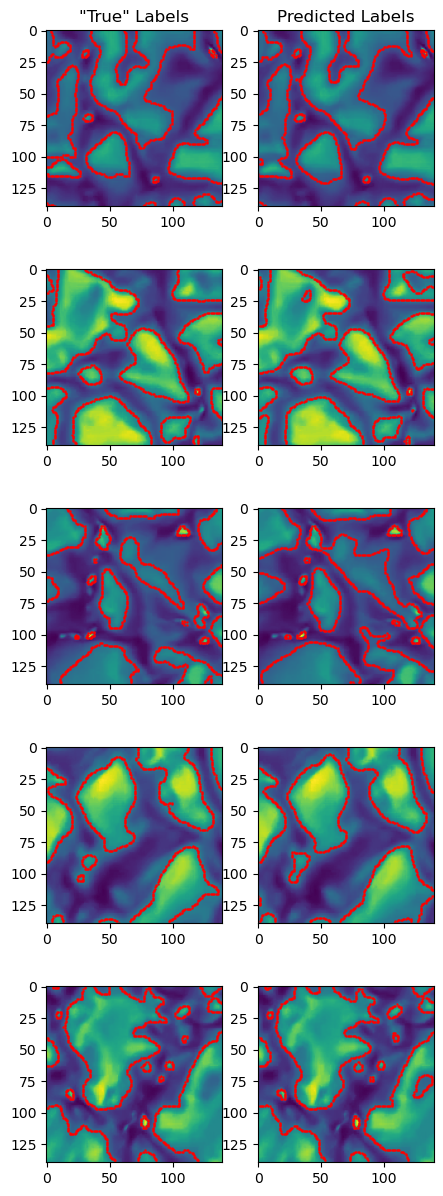

In [2]:
# Compute total validation accuracy
num_correct = 0
num_pixels = 0
for idx in range(396):
    true = np.load(f'../UNet3_outputs/true_{idx}.npy').astype(np.uint8)
    preds = np.squeeze(np.load(f'../UNet3_outputs/pred_{idx}.npy')).astype(np.uint8)
    num_correct += len(np.where(preds.flatten() == true.flatten())[0]) #(preds == true).sum()
    num_pixels += len(preds.flatten()) # torch.numel(preds)
print(f"Total validation accuracy: {num_correct/num_pixels*100:.2f}") 

# Display a random sample of images
import cv2
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10)) = plt.subplots(5, 2, figsize=(5, 15)); axs = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10]
ax1.set_title('"True" Labels')
ax2.set_title('Predicted Labels')
for i in range(0, 9, 2):
    idx = np.random.randint(0, 396)
    im = np.load(f'../UNet3_outputs/x_{idx}.npy')
    true = np.load(f'../UNet3_outputs/true_{idx}.npy').astype(np.uint8)
    pred = np.squeeze(np.load(f'../UNet3_outputs/pred_{idx}.npy')).astype(np.uint8)
    true_edges = cv2.Canny(true, 0, 1)
    pred_edges = cv2.Canny(pred, 0, 1)
    x_true = np.where(true_edges!=0)[0]
    y_true = np.where(true_edges!=0)[1]
    x_pred = np.where(pred_edges!=0)[0]
    y_pred = np.where(pred_edges!=0)[1]
    axs[i].imshow(im)
    axs[i].scatter(y_true, x_true, s=0.5, color='red')
    axs[i+1].imshow(im)
    axs[i+1].scatter(y_pred, x_pred, s=0.5, color='red')


In [ ]:
'''
UNet4 (binary labels, multiple channels)
'''
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import os
from PIL import Image
from torch.utils.data import Dataset, TensorDataset, DataLoader
from albumentations.pytorch import ToTensorV2
import torchvision 
import torchvision.transforms.functional as TF
from tqdm import tqdm
import torch.optim as optim


# Creat class for convenience to load in data (inherates from torch Dataset class)
class MyDataset(Dataset):

    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index]) # path to one data image
        mask_path = os.path.join(self.mask_dir, 'SEG_'+self.images[index]) # path to one labels image THIS SHOULD ENSURE ITS THE MASK CORRESPONDING TO THE CORRECT IMAGE
        img = np.load(img_path).newbyteorder().byteswap()  # I think this is the issue??
        mask = np.load(mask_path).newbyteorder().byteswap() 
        if self.transform is not None:
            augmentations = self.transform(image=img, mask=mask)
            img = augmentations["image"]
            mask = augmentations["mask"]
        # Add feature layers
        image = np.zeros((3, img.shape[0], img.shape[1]), dtype=np.float32) # needs to be float32 not float64
        image[0, :, :] = img
        image[1, :, :] = np.gradient(img)[0]
        image[2, :, :] = np.gradient(img)[1]
        return image, mask

# Define class DoubleConv to create a containor for multiple layers (for convenience)
class DoubleConv(nn.Module):

    def __init__(self, in_channels, out_channels):

        # Call init method inherated from nn.Module
        super(DoubleConv, self).__init__()
        # Define layer that is a bunch of layers
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding='same', bias=False),
            nn.BatchNorm2d(out_channels), 
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding='same', bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            )

    def forward(self, x): # this is what gets called when you call DoubleConv

        #print(f'\t\tCalling MyUNet.DoubleConv foward with x shape {x.shape}, with first Conv2d layer {self.conv[0]}')
        return self.conv(x)

# Define class MyUNet
class MyUNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],): # Changed in_channels from 3 to 1, becasue I have 1-channel images not rgb
        
        print('Initializing MyUNet')

        # Call init method inherated from nn.Module
        super(MyUNet, self).__init__()
        # Initialize two lists of layers: one for down one for up
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        # Define pooling layer (recall: this is not saying the pooling layer is called after the up and down stuff; its just defining the up, down, and pool attributes all together here)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fill list of down layers 
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            # after each convolution we set (next) in_channel to (previous) out_channels  
            in_channels = feature

        # Fill list of up layers 
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2,))
            self.ups.append(DoubleConv(feature*2, feature))

        # Define layer at the bottom (??????)
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)

        # Define last conv to get correct output num channels
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x): # this is what gets called when you call MyUNet
        
        # Initialize list to store skip connections
        skip_connections = []

        # Do all the downs in self.downs
        for down in self.downs:
            x = down(x) # the down layers are all MyUNet.DoubleConv, which is a set of layers within a nn.Sequential containor 
            skip_connections.append(x) # NEED TO LEARN ABOUT SKIP_CONNECTIONS
            x = self.pool(x)

        # Perform bottleneck layer
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1] # reverse 

        # Do all the ups in self.ups
        for idx in range(0, len(self.ups), 2): # step of 2 becasue add conv step
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2] # // inte
            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])
            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

# Create training function to train one epoch
def train_fn(loader, model, optimizer, loss_fn, scaler):
    
    loop = tqdm(loader) # is this a progress bar? but then below its looping through loop

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device="cpu")
        targets = targets.float().unsqueeze(1).to(device="cpu")

        # forward
        predictions = model(data) # call model to get predictions  # NOTE: wait, why not torch.sigmoid(model(x)) ??? Isnt that how we get the predictions??
        loss = loss_fn(predictions, targets) # compute loss

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # # update tqdm loop
        loop.set_postfix(loss=loss.item()) # 

# Get the data, applying some transformations
batch_size = 16
train_ds = MyDataset(image_dir="../Data/UNetData/images/train", mask_dir="../Data/UNetData/seg_images_binary/train")#, transform=train_transform)
train_loader = DataLoader(train_ds, batch_size=batch_size, num_workers=2, pin_memory=True, shuffle=True)
val_ds = MyDataset(image_dir="../Data/UNetData/images/val", mask_dir="../Data/UNetData/seg_images_binary/val")#, transform=val_transform)
val_loader = DataLoader(val_ds, batch_size=batch_size, num_workers=2, pin_memory=True, shuffle=False)

# Check data is loaded correctly
print('Train data:')
print(f'     {len(train_ds)} obs, broken into {len(train_loader)} batches')
train_features, train_labels = next(iter(train_loader))
shape = train_features.size()
print(f'     Each batch is shape {train_features.size()}, e.g. {shape[0]} images, {[shape[2], shape[3]]} pixels each, {shape[1]} layers (features)')

# Define model (as an instance of MyNeuralNet), loss function, and optimizer
model = MyUNet(in_channels=3, out_channels=1).to("cpu") # NOTE: FOR MULTICLASS, CHANGE OUT_CHANNELS TO NUM CLASSES!!!
loss_fn = nn.BCEWithLogitsLoss() # NOTE: FOR MULTICLASS, USE CROSS ENTROPY LOSS!!!
optimizer = optim.Adam(model.parameters(), lr=1e-4)
load_model = False
if load_model:
    checkpoint = torch.load("my_checkpoint.pth.tar")
    model.load_state_dict(checkpoint["state_dict"])

# Train
print('Training:')
num_epochs = 3
scaler = torch.cuda.amp.GradScaler() # Don't have cuda
for epoch in range(num_epochs):
    print(f'\tEpoch {epoch}')

    # Train
    train_fn(train_loader, model, optimizer, loss_fn, scaler) # call model

    # check accuracy (e.g. test? during the training?) NOTE: WILL NOT WORK FOR MULTICLASS
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval() # set model into eval mode
    with torch.no_grad():
        for x, y in val_loader:
            x = x.to("cpu")
            y = y.to("cpu").unsqueeze(1)
            preds = torch.sigmoid(model(x)) # call model to get predictions
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / ((preds + y).sum() + 1e-8)
    print(f"\tGot {num_correct}/{num_pixels} correct (accuracy {num_correct/num_pixels*100:.2f})")
    print(f"\tDice score: {dice_score/len(val_loader)}")
    model.train() # set model back into train mode

# Save model
torch.save(model.state_dict(), '../NN_storage/UNet4.pth')
print('Saving trained model as NN_storage/UNet4.pth')

# Load it back in and save results on validation data 
model = MyUNet()
model.load_state_dict(torch.load('../NN_storage/UNet4.pth'))
print('Loading model back in, saving results on validation data in UNet4_outputs')
i = 0
for X, y in val_loader:
    X, y = X.to('cpu'), y.to('cpu')
    with torch.no_grad():
        preds = torch.sigmoid(model(X))
    preds = (preds > 0.5).float()
    for j in range(np.shape(preds)[0]):
        np.save(f'../UNet4_outputs/x_{i}', np.array(X[j]))
        np.save(f'../UNet4_outputs/true_{i}', np.array(y[j]))
        np.save(f'../UNet4_outputs/pred_{i}', np.array(preds[j]))
        i += 1

Total validation accuracy: 97.55


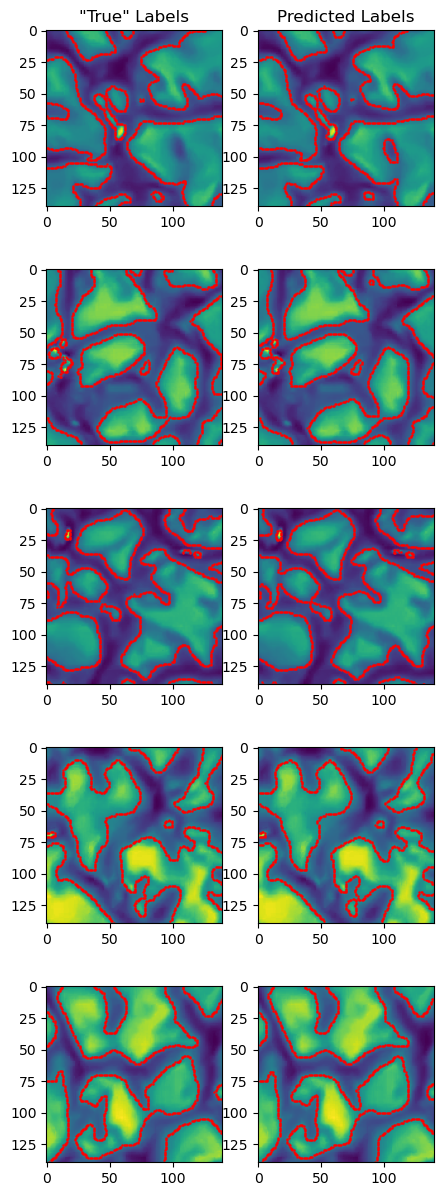

In [2]:
# Compute total validation accuracy
num_correct = 0
num_pixels = 0
for idx in range(396):
    true = np.load(f'../UNet4_outputs/true_{idx}.npy').astype(np.uint8)
    preds = np.squeeze(np.load(f'../UNet4_outputs/pred_{idx}.npy')).astype(np.uint8)
    num_correct += len(np.where(preds.flatten() == true.flatten())[0]) #(preds == true).sum()
    num_pixels += len(preds.flatten()) # torch.numel(preds)
print(f"Total validation accuracy: {num_correct/num_pixels*100:.2f}") 

# Display a random sample of images
import cv2
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10)) = plt.subplots(5, 2, figsize=(5, 15)); axs = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10]
ax1.set_title('"True" Labels')
ax2.set_title('Predicted Labels')
for i in range(0, 9, 2):
    idx = np.random.randint(0, 396)
    im = np.load(f'../UNet4_outputs/x_{idx}.npy')[0] # first index to get image
    true = np.load(f'../UNet4_outputs/true_{idx}.npy').astype(np.uint8)
    pred = np.squeeze(np.load(f'../UNet4_outputs/pred_{idx}.npy')).astype(np.uint8)
    true_edges = cv2.Canny(true, 0, 1)
    pred_edges = cv2.Canny(pred, 0, 1)
    x_true = np.where(true_edges!=0)[0]
    y_true = np.where(true_edges!=0)[1]
    x_pred = np.where(pred_edges!=0)[0]
    y_pred = np.where(pred_edges!=0)[1]
    axs[i].imshow(im)
    axs[i].scatter(y_true, x_true, s=0.5, color='red')
    axs[i+1].imshow(im)
    axs[i+1].scatter(y_pred, x_pred, s=0.5, color='red')

In [ ]:
'''
UNet2 (four-valued labels)
THIS WOKRS BUT NOT WELL AT ALL
'''
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import os
from PIL import Image
from torch.utils.data import Dataset, TensorDataset, DataLoader
from albumentations.pytorch import ToTensorV2
import torchvision 
import torchvision.transforms.functional as TF
from tqdm import tqdm
import torch.optim as optim

# Creat class for convenience to load in data (inherates from torch Dataset class)
class MyDataset(Dataset):

    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index]) # path to one data image
        mask_path = os.path.join(self.mask_dir, 'SEG_'+self.images[index]) # path to one labels image THIS SHOULD ENSURE ITS THE MASK CORRESPONDING TO THE CORRECT IMAGE
        img = np.load(img_path).newbyteorder().byteswap()  
        labels = np.load(mask_path).newbyteorder().byteswap() 
        if self.transform is not None:
            augmentations = self.transform(image=img, mask=mask)
            img = augmentations["image"]
            mask = augmentations["mask"]
        # Add dummy axis so that torch has correct number of dimensions
        image = np.zeros((1, img.shape[0], img.shape[1]), dtype=np.float32) # needs to be float32 not float64
        image[0, :, :] = img
        # One-hot encode targets so they are the correct size
        mask = np.zeros((4, labels.shape[0], labels.shape[1]), dtype=np.float32) # needs to be float32 not float64
        mask_gr, mask_ig, mask_bp, mask_dm = np.zeros_like(labels), np.zeros_like(labels), np.zeros_like(labels), np.zeros_like(labels)
        mask_ig[labels == 0] = 1 # 1 where intergranule (), 0 elsewhere
        mask_dm[labels == 0.5] = 1 # 1 where dim middle (), 0 elsewhere
        mask_gr[labels == 1] = 1 # 1 where granule (), 0 elsewhere
        mask_bp[labels == 1.5] = 1 # 1 where bright point (), 0 elsewhere
        mask[0, :, :] = mask_ig
        mask[1, :, :] = mask_dm
        mask[2, :, :] = mask_gr
        mask[3, :, :] = mask_bp
        return image, mask

# Define class DoubleConv to create a containor for multiple layers (for convenience)
class DoubleConv(nn.Module):

    def __init__(self, in_channels, out_channels):

        # Call init method inherated from nn.Module
        super(DoubleConv, self).__init__()
        # Define layer that is a bunch of layers
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding='same', bias=False),
            nn.BatchNorm2d(out_channels), 
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding='same', bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            )

    def forward(self, x): # this is what gets called when you call DoubleConv

        # print(f'\t\tCalling MyUNet.DoubleConv foward with x shape {x.shape}, with first Conv2d layer {self.conv[0]}')
        return self.conv(x)

# Define class MyUNet
class MyUNet(nn.Module):

    def __init__(self, in_channels=1, out_channels=4, features=[64, 128, 256, 512],): # Changed in_channels from 3 to 1, becasue I have 1-channel images not rgb
        print('Initializing MyUNet')

        # Call init method inherated from nn.Module
        super(MyUNet, self).__init__()
        # Initialize two lists of layers: one for down one for up
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        # Define pooling layer (recall: this is not saying the pooling layer is called after the up and down stuff; its just defining the up, down, and pool attributes all together here)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fill list of down layers 
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            # after each convolution we set (next) in_channel to (previous) out_channels  
            in_channels = feature

        # Fill list of up layers 
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2,))
            self.ups.append(DoubleConv(feature*2, feature))

        # Define layer at the bottom (??????)
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)

        # Define last conv to get correct output num channels
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x): # this is what gets called when you call MyUNet

        # Initialize list to store skip connections
        skip_connections = []

        # Do all the downs in self.downs
        for down in self.downs:
            x = down(x) # the down layers are all MyUNet.DoubleConv, which is a set of layers within a nn.Sequential containor 
            skip_connections.append(x) # NEED TO LEARN ABOUT SKIP_CONNECTIONS
            x = self.pool(x)

        # Perform bottleneck layer
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1] # reverse 

        # Do all the ups in self.ups
        for idx in range(0, len(self.ups), 2): # step of 2 becasue add conv step
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]
            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])
            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

# Create training function to train one epoch
def train_fn(loader, model, optimizer, loss_fn, scaler):
    
    loop = tqdm(loader) # is this a progress bar? but then below its looping through loop

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device="cpu")
        # targets = targets.float().unsqueeze(1).to(device="cpu") # shape [16, 1, 4, 140, 140]
        targets = targets.float().to(device='cpu') # shape [16, 4, 140, 140]

        # call model to get predictions
        predictions = model(data) # shape [16, 4, 140, 140] --> one-hot encoded??
        loss = loss_fn(predictions, targets) # compute loss

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # # update tqdm loop
        loop.set_postfix(loss=loss.item()) 

# Get the data, applying some transformations (Should pull segs and truths correctly based on their positions in the directories)
batch_size = 16
train_ds = MyDataset(image_dir="../Data/UNetData/images/train", mask_dir="../Data/UNetData/seg_images/train")#, transform=train_transform)
train_loader = DataLoader(train_ds, batch_size=batch_size, num_workers=2, pin_memory=True, shuffle=True)
val_ds = MyDataset(image_dir="../Data/UNetData/images/val", mask_dir="../Data/UNetData/seg_images/val")#, transform=val_transform)
val_loader = DataLoader(val_ds, batch_size=batch_size, num_workers=2, pin_memory=True, shuffle=False)

# Check data is loaded correctly
print('Train data:')
print(f'     {len(train_ds)} obs, broken into {len(train_loader)} batches')
train_features, train_labels = next(iter(train_loader))
shape = train_features.size()
print(f'     Each batch has features of shape {train_features.size()}, e.g. {shape[0]} images, {[shape[2], shape[3]]} pixels each, {shape[1]} layers (features)')
shape = train_labels.size()
print(f'     Each batch has labels of shape {train_labels.size()}, e.g. {shape[0]} images, {[shape[2], shape[3]]} pixels each, {shape[1]} layers (classes)')

# Define model (as an instance of MyNeuralNet), loss function, and optimizer
model = MyUNet(in_channels=1, out_channels=4).to("cpu") # NOTE: FOR MULTICLASS, CHANGE OUT_CHANNELS TO NUM CLASSES!!!
loss_fn = nn.CrossEntropyLoss() # NOTE: FOR MULTICLASS, USE CROSS ENTROPY LOSS!!!
optimizer = optim.Adam(model.parameters(), lr=1e-4)
load_model = False
if load_model:
    checkpoint = torch.load("my_checkpoint.pth.tar")
    model.load_state_dict(checkpoint["state_dict"])

# Train
print('Training:')
num_epochs = 3
scaler = torch.cuda.amp.GradScaler() # Don't have cuda
for epoch in range(num_epochs):
    print(f'\tEpoch {epoch}')

    # Train
    train_fn(train_loader, model, optimizer, loss_fn, scaler) # call model

    # check accuracy (e.g. test? during the training?) NOTE: WILL NOT WORK FOR MULTICLASS
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval() # set model into eval mode
    with torch.no_grad():
        for x, y in val_loader:
            x = x.to("cpu")
            y = y.to("cpu") #.unsqueeze(1)
            preds = torch.sigmoid(model(x)) # call model to get predictions

            preds = np.argmax(preds.detach().numpy(), axis=1) 
            y = np.argmax(y.detach().numpy(), axis=1)

            # LOOK AT SSIM AND OTHERS
            # preds = (preds > 0.5).float()
            num_correct += len(np.where(preds == y)[0]) #(preds == y).sum()
            num_pixels += len(preds.flatten()) # torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / ((preds + y).sum() + 1e-8)
    print(f"\tGot {num_correct}/{num_pixels} correct (accuracy {num_correct/num_pixels*100:.2f})") 
    print(f"\tDice score: {dice_score/len(val_loader)}")
    model.train() # set model back into train mode

# Save model 
torch.save(model.state_dict(), '../NN_storage/UNet2.pth')
print('Saving trained model as UNet2.pth')

# Load it back in and save results on validation data 
model = MyUNet()
model.load_state_dict(torch.load('../NN_storage/UNet2.pth'))
print('Loading model back in, saving results on validation data in UNet2_outputs')
i = 0 
for X, y in val_loader:
    X, y = X.to('cpu'), y.to('cpu')
    with torch.no_grad():
        preds = torch.sigmoid(model(X))
    preds = np.argmax(preds.detach().numpy(), axis=1) 
    preds = preds/2 # change from idx to class value 0 -> 0 (IG), 1 -> 0.5 (DM), 2 -> 1 (G), 3 -> 1.5 (BP)
    y = np.argmax(y.detach().numpy(), axis=1)
    y = y/2 # change from idx to class value 0 -> 0 (IG), 1 -> 0.5 (DM), 2 -> 1 (G), 3 -> 1.5 (BP)
    # preds = (preds > 0.5).float()
    for j in range(np.shape(preds)[0]):
        np.save(f'../UNet2_outputs/x_{i}', np.array(X[j]))
        np.save(f'../UNet2_outputs/true_{i}', np.array(y[j]))
        np.save(f'../UNet2_outputs/pred_{i}', np.array(preds[j]))
        i += 1


Total validation accuracy: 96.48


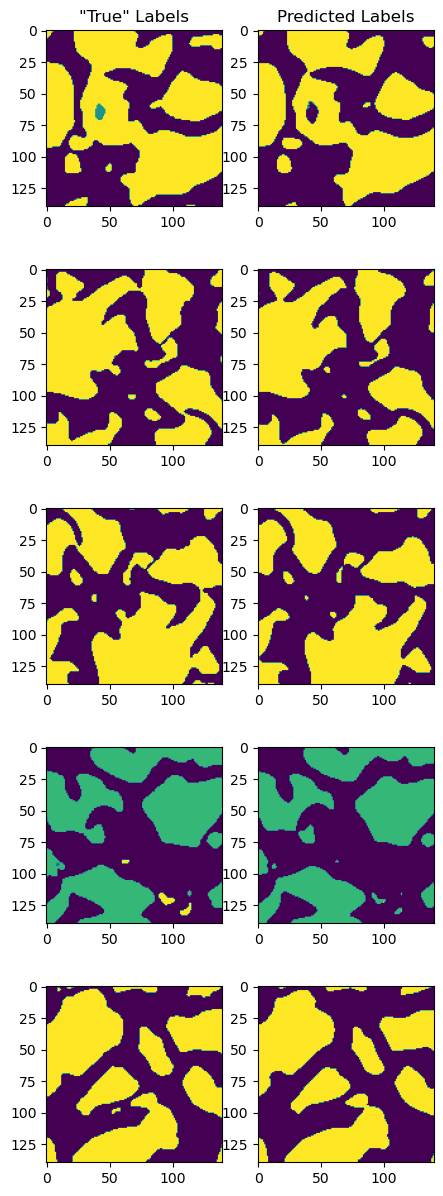

In [2]:
# Compute total validation accuracy
num_correct = 0
num_pixels = 0
for idx in range(396):
    true = np.load(f'../UNet2_outputs/true_{idx}.npy')
    preds = np.squeeze(np.load(f'../UNet2_outputs/pred_{idx}.npy'))
    num_correct += len(np.where(preds.flatten() == true.flatten())[0]) #(preds == true).sum()
    num_pixels += len(preds.flatten()) # torch.numel(preds)
print(f"Total validation accuracy: {num_correct/num_pixels*100:.2f}") 

# Display a random sample of images
import cv2
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10)) = plt.subplots(5, 2, figsize=(5, 15)); axs = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10]
ax1.set_title('"True" Labels')
ax2.set_title('Predicted Labels')
for i in range(0, 9, 2):
    idx = np.random.randint(0, 396)
    im = np.load(f'../UNet2_outputs/x_{i}.npy')[0] # first index to get image
    true = np.load(f'../UNet2_outputs/true_{i}.npy')
    preds = np.squeeze(np.load(f'../UNet2_outputs/pred_{i}.npy'))
    # true_edges = cv2.Canny(true, 0, 1)
    # pred_edges = cv2.Canny(pred, 0, 1)
    # x_true = np.where(true_edges!=0)[0]
    # y_true = np.where(true_edges!=0)[1]
    # x_pred = np.where(pred_edges!=0)[0]
    # y_pred = np.where(pred_edges!=0)[1]
    axs[i].imshow(true)
    axs[i+1].imshow(preds)
 